In [6]:
from alpha_vantage.foreignexchange import ForeignExchange
import matplotlib.pyplot as plt
cc = ForeignExchange(key='OGRPFV5D58LC77OL',output_format='pandas')
import pandas as pd
from datetime import datetime
import numpy as np
from numpy.polynomial.polynomial import polyfit

dfm = pd.DataFrame()
dfw = pd.DataFrame()
dfd = pd.DataFrame()

if dfm.empty:
    dfm, meta_data = cc.get_currency_exchange_monthly(from_symbol='EUR',to_symbol='USD', outputsize='full')

if dfw.empty:
    dfw, meta_data = cc.get_currency_exchange_weekly(from_symbol='EUR',to_symbol='USD', outputsize='full')  
    
if dfd.empty:
   dfd, meta_data = cc.get_currency_exchange_daily(from_symbol='EUR',to_symbol='USD', outputsize='full')


df60, meta_data = cc.get_currency_exchange_intraday(from_symbol='EUR',to_symbol='USD',interval='60min', outputsize='full')

In [7]:
def clean_Columns(df):
    if 'errorslope' not in df.columns:
        df.reset_index(inplace=True) #reset index to get timestamp out
        df.columns = ['date','open','high','low','close'] #Make sure column names are legit  
        df['index'] = np.arange(len(df)) #create an index 
        df['errorslope']=np.nan
        df['errorslopediff']=np.nan
    return df

#Cleanup columns
clean_Columns(dfm)
clean_Columns(dfw)
clean_Columns(dfd)

df60.reset_index(inplace=True) #reset index to get timestamp out
df60.columns = ['timestamp','open','high','low','close'] #Make sure column names are legit    

df60 = df60[df60.timestamp.dt.weekday < 5] #Filter out all weekend data
df60['index'] = np.arange(len(df60)) #create an index 
df60['errorslope']=np.nan
df60['errorslopediff']=np.nan

## Make copies and Reshape the data

In [57]:
#Make copies
dfm_copy = dfm.copy()
dfw_copy = dfw.copy()
dfd_copy = dfd.copy()

#Filter the dates
dfm_copy = dfm_copy[dfm_copy['index'] < 24]
dfw_copy = dfw_copy[dfw_copy['index'] < 12]
dfd_copy = dfd_copy[dfd_copy['index'] < 30]

#Reshape for plotting
#dfm_copy.sort_values(by='date')

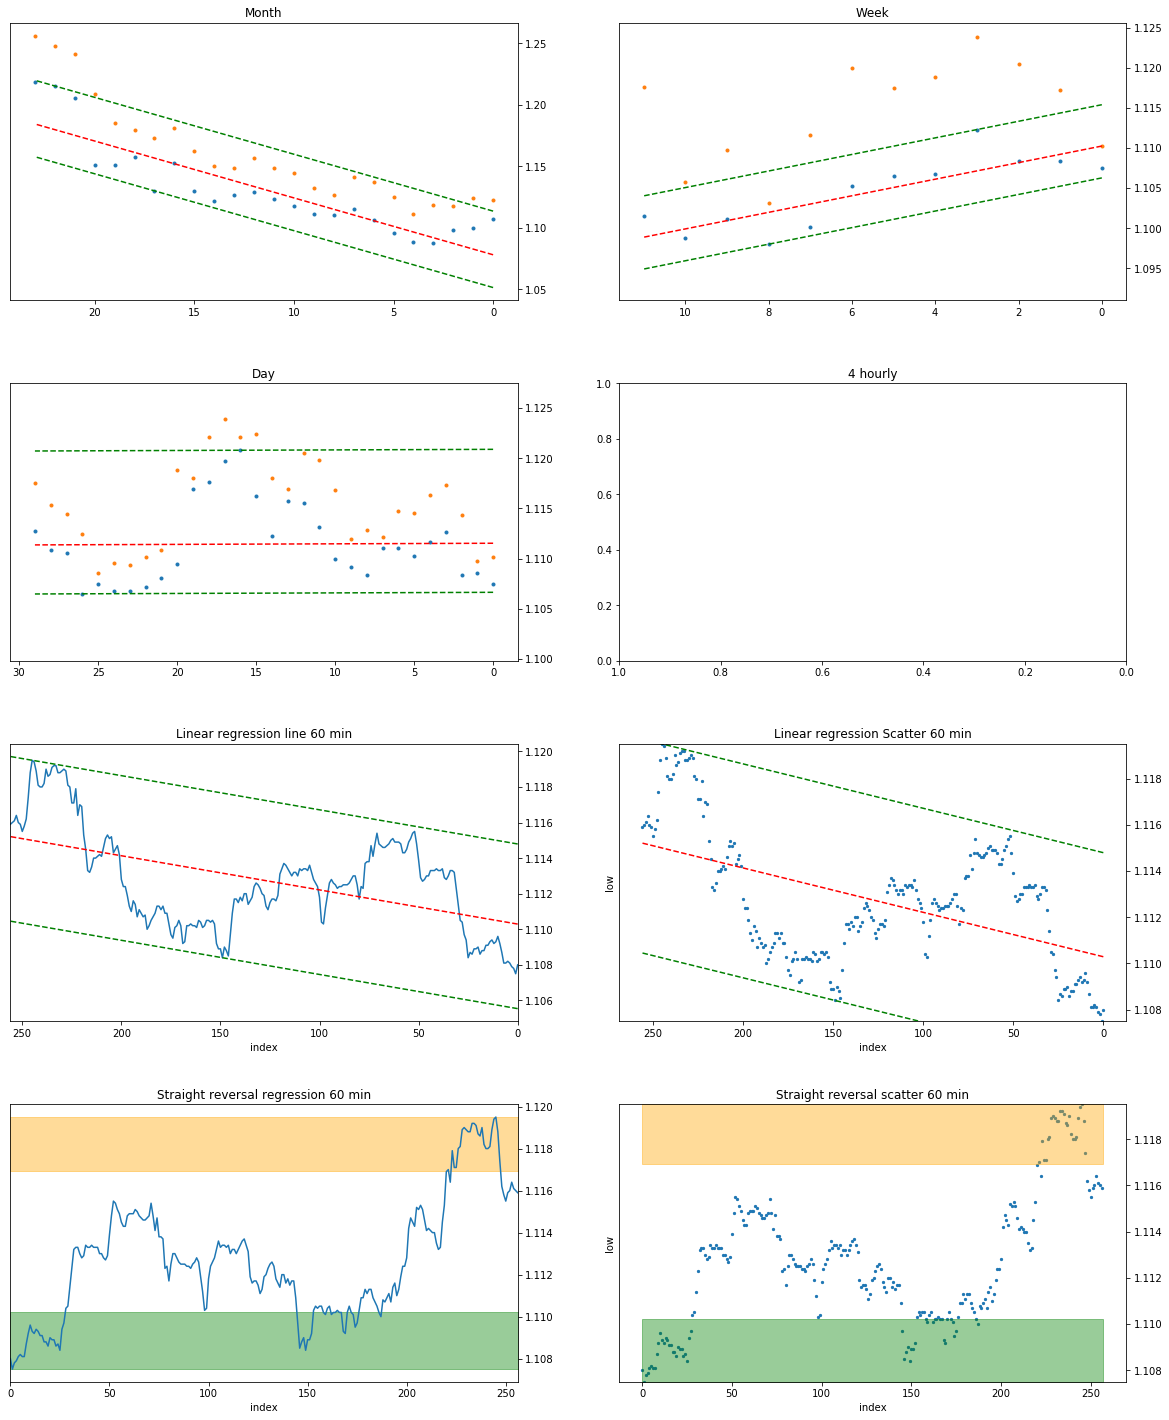

In [62]:
_val = 'low'
_low = 'low'

#_monthsback = 

def Set_Ylim(df,ax):
    ax.set_ylim([df[_val].min(),df[_val].max()])

def Plot_HiLowBars(df,ax):
    ax.fill_between([0,df['index'].count()],df[_low].quantile(0.2), df[_low].min(),alpha=0.4,color='green')
    ax.fill_between([0,df['index'].count()],df[_low].max(),df[_low].quantile(0.9),alpha=0.4,color='orange')
    ax.yaxis.tick_right()
    ax.invert_xaxis()

def Plot_errorLine(df,ax):
    b, m = polyfit(df['index'], df[_val], 1)
    ax.plot(df['index'], b + m * df['index'], 'r--')
    ax.yaxis.tick_right()
    #ax.invert_xaxis()
    for index, row in df.iterrows(): #Calculate the difference between the regression line and high/low
      df.errorslope = b + m * df['index']
      df.errorslopediff = df[_val] - df.errorslope
    #Calculate min and max difference and plot new slops at these extremes
    maxdiff = df.errorslopediff.max()
    mindiff = df.errorslopediff.min()
    ax.plot(df['index'], maxdiff + (b + m * df['index']), 'g--')
    ax.plot(df['index'], mindiff + (b + m * df['index']), 'g--')

    
    
#Set the main figure proportions
fig = plt.figure(figsize=(20,25))
fig.subplots_adjust(hspace=0.3)

# Divide the figure into a 2x2 grid, and set sections to ax1 and ax2
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)


#Monthly
ax1.scatter(dfm_copy['index'], dfm_copy['low'], marker='.')
ax1.scatter(dfm_copy['index'], dfm_copy['high'], marker='.')

#Weekly
ax2.scatter(dfw_copy['index'], dfw_copy['low'], marker='.')
ax2.scatter(dfw_copy['index'], dfw_copy['high'], marker='.')

#Daily
ax3.scatter(dfd_copy['index'], dfd_copy['low'], marker='.')
ax3.scatter(dfd_copy['index'], dfd_copy['high'], marker='.')

#60 minute
df60.plot(x='index', y=_val, ax=ax5, legend=False)
df60.plot(x='index', y=_val, ax=ax6, kind = 'scatter', marker='.')
df60.plot(x='index', y=_val, ax=ax7, legend=False)
df60.plot(x='index', y=_val, ax=ax8, kind = 'scatter',marker='.')

#for some reason I have to invert these axis
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
ax7.invert_xaxis()
ax8.invert_xaxis()

#ax1.yaxis.set_label_text("Month")
ax1.set_title("Month")
ax2.set_title("Week")
ax3.set_title("Day")
ax4.set_title("4 hourly")
ax5.set_title('Linear regression line 60 min')
ax6.set_title('Linear regression Scatter 60 min')
ax7.set_title('Straight reversal regression 60 min')
ax8.set_title('Straight reversal scatter 60 min')

# Set_Ylim(dfm_copy,ax1)
# Set_Ylim(dfw_copy,ax2)
# Set_Ylim(dfd_copy,ax3)
Set_Ylim(df60,ax6)
Set_Ylim(df60,ax8)

Plot_errorLine(dfm_copy,ax1)
Plot_errorLine(dfw_copy,ax2)
Plot_errorLine(dfd_copy,ax3)
Plot_errorLine(df60,ax5)
Plot_errorLine(df60,ax6)

Plot_HiLowBars(df60,ax7)
Plot_HiLowBars(df60,ax8)


In [108]:
#df = df60.copy()
#df60[df60.timestamp > '2020-01-12 18:00:00']
#df[df['timestamp'].isin(['2020-01-13','2020-01-07'])]
#df.mean()
#pieces = [df[:1], df[:3], df[4:]] # Chop a datraframe into pieces
#df['day'] = df['timestamp'].dt.day_name() #Create a column of day names
#df.groupby('day')
#df.set_index('day', inplace=True)
#pd.set_option('display.max_rows', 500)
gf = df.copy()

In [2]:
#gf.set_index(['day','Date','time'], inplace=True)

In [ ]:
gf = gf.groupby(['day','Date','time']).sum()

In [ ]:
gf.to_csv('filtered.csv')

In [ ]:
gf.dtypes

In [ ]:
# extracting date from timestamp
gf['Date'] = gf['timestamp'].dt.date
gf['time'] = gf['timestamp'].dt.time


In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
stacked = gf.stack()

In [13]:
#stacked.tail(50)
#gf = df.copy()
#gf['timestamp'].resample('2H').mean()
print(dfm_copy.columns)
print(dfw_copy.columns)
print(dfd_copy.columns)

Index(['date', 'open', 'high', 'low', 'close', 'index', 'errorslope',
       'errorslopediff'],
      dtype='object')
Index(['date', 'open', 'high', 'low', 'close', 'index', 'errorslope',
       'errorslopediff'],
      dtype='object')
Index(['date', 'open', 'high', 'low', 'close', 'index', 'errorslope',
       'errorslopediff'],
      dtype='object')


In [63]:
dfm

,date,open,high,low,close,index,errorslope,errorslopediff
0,2020-01-20,1.1212,1.1224,1.1075,1.1082,0,1.202730,-0.095230
1,2019-12-31,1.1014,1.1239,1.1001,1.1213,1,1.202859,-0.102759
2,2019-11-29,1.1152,1.1176,1.0980,1.1017,2,1.202988,-0.104988
3,2019-10-31,1.0898,1.1183,1.0878,1.1151,3,1.203117,-0.115317
4,2019-09-30,1.0987,1.1110,1.0884,1.0898,4,1.203246,-0.114846
...,...,...,...,...,...,...,...,...
212,2002-05-31,0.9004,0.9414,0.8988,0.9323,212,1.230104,-0.331304
213,2002-04-30,0.8715,0.9049,0.8709,0.9006,213,1.230233,-0.359333
214,2002-03-29,0.8686,0.8868,0.8628,0.8714,214,1.230362,-0.367562
215,2002-02-28,0.8586,0.8800,0.8560,0.8687,215,1.230492,-0.374492
